In [8]:
import numpy as np

np.random.seed(1337)  # for reproducibility
from keras.models import *
from keras.layers import Input, Dense, merge
from keras.layers.recurrent import LSTM

# plot part.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
x = Input(shape=(10,2))

In [19]:
x.shape

TensorShape([Dimension(None), Dimension(10), Dimension(2)])

In [21]:
help(LSTM)

Help on class LSTM in module keras.layers.recurrent:

class LSTM(Recurrent)
 |  Long-Short Term Memory unit - Hochreiter 1997.
 |  
 |  For a step-by-step description of the algorithm, see
 |  [this tutorial](http://deeplearning.net/tutorial/lstm.html).
 |  
 |  # Arguments
 |      units: Positive integer, dimensionality of the output space.
 |      activation: Activation function to use
 |          (see [activations](../activations.md)).
 |          If you pass None, no activation is applied
 |          (ie. "linear" activation: `a(x) = x`).
 |      recurrent_activation: Activation function to use
 |          for the recurrent step
 |          (see [activations](../activations.md)).
 |      use_bias: Boolean, whether the layer uses a bias vector.
 |      kernel_initializer: Initializer for the `kernel` weights matrix,
 |          used for the linear transformation of the inputs.
 |          (see [initializers](../initializers.md)).
 |      recurrent_initializer: Initializer for the `r

In [23]:
encoder(x)

<tf.Tensor 'lstm_3/transpose_1:0' shape=(?, ?, 32) dtype=float32>

In [22]:
#inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))

model = Sequential()
model.add(LSTM(32))
model.add()
def encoder(x):
    lstm_units = 32
    lstm_out = LSTM(lstm_units)(x)
    
    return lstm_out

def attention(x):
    attention_probs = Dense(x.shape[1:], activation='softmax', name='attention_vec')(x)
    attention_mul = merge([x, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    return attention_mul

def decoder(x):
    lstm_units

In [10]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y



/home/jay/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/jay/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/jay/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32)            0                                            
____________________________________________________________________________________________________
attention_vec (Dense)            (None, 32)            1056        input_1[0][0]                    
____________________________________________________________________________________________________
attention_mul (Merge)            (None, 32)            0           input_1[0][0]                    
                                                                   attention_vec[0][0]              
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 64)            2112        attention_mul[0][0]     

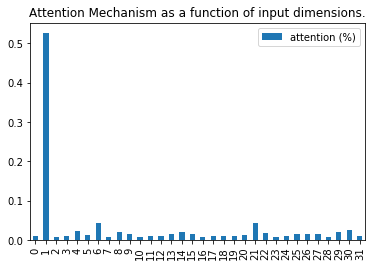

In [6]:
input_dim = 32

def build_model():
    inputs = Input(shape=(input_dim,))

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


if __name__ == '__main__':
    N = 10000
    inputs_1, outputs = get_data(N, input_dim)

    m = build_model()
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(m.summary())

    m.fit([inputs_1], outputs, epochs=20, batch_size=64, validation_split=0.5)

    testing_inputs_1, testing_outputs = get_data(1, input_dim)

    # Attention vector corresponds to the second matrix.
    # The first one is the Inputs output.
    attention_vector = get_activations(m, testing_inputs_1,
                                       print_shape_only=True,
                                       layer_name='attention_vec')[0].flatten()
    print('attention =', attention_vector)

    # plot part.
    import matplotlib.pyplot as plt
    import pandas as pd

    pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar',
                                                                   title='Attention Mechanism as '
                                                                         'a function of input'
                                                                         ' dimensions.')
    plt.show()